# Classifier using LSTM layers

## 1. Importing Libraries

In [29]:
import torch

import pennylane as qml
import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 40

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [30]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories
    
    return categories[:n]

classes = get_categories_from_data(data_folder)
class_id = dict(zip(classes, range(len(classes))))


camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [31]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes
    
    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)
    
    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]
    
    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0
    
    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]
    
    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)


# TODO: Limitar dataset
resized_cellphone_drawings = resized_cellphone_drawings[:5000]
resized_camera_drawings = resized_camera_drawings[:5000]

resized_camera_drawings.shape, resized_cellphone_drawings.shape

((5000, 95, 3), (5000, 95, 3))

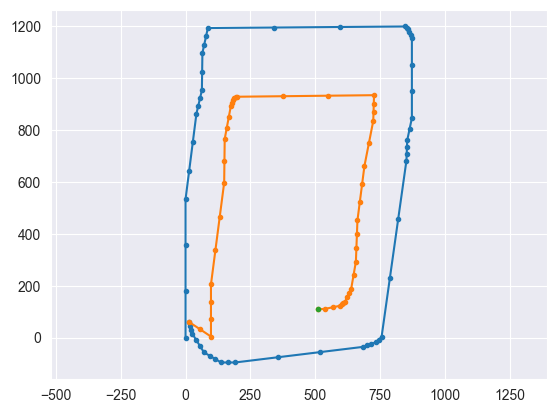

In [32]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()
    
    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()
    
draw_strokes(resized_cellphone_drawings[0])

In [33]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras and cellphones.
    
    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    test_size (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.zeros(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0])
    
    # Combine the drawings from both categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels], axis=0)
    
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, test_size=0.2)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 95, 3), (8000,), (2000, 95, 3), (2000,))

In [35]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.
    
    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
    
    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
print(len(train_loader))
print(len(test_loader))

200
50


## 3. Model Building

### 3.1. Quantum Layer

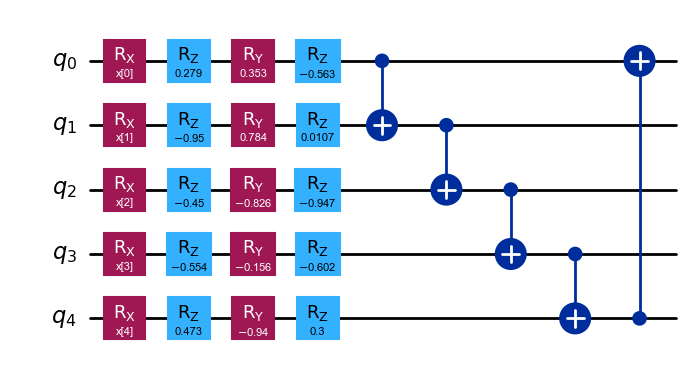

In [37]:
import random
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def generate_random_params(num_params, lower_bound=-1, upper_bound=1, seed=None):
    if seed is not None:
        random.seed(seed)
    return [random.uniform(lower_bound, upper_bound) for _ in range(num_params)]

def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    # Generar valores aleatorios para los parámetros del ansatz con una semilla
    fixed_params = generate_random_params(3 * n, seed=42)
    parameter_values = {param: value for param, value in zip(ansatz.parameters, fixed_params)}
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz.assign_parameters(parameter_values), inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=None,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)
        
        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        
        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])
        
        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)
        
        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)
        
        # Flatten the output for dense layer
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        
        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [39]:
checkpoint_filepath = 'models/2edition_quantum_lstm_qfixed/best_model_weights.pth'

In [40]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            
            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch 1, Accuracy: 0.4985, Loss: 0.6516863504052162, Validation Accuracy: 0.506, Validation Loss: 0.6203645467758179


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch 2, Accuracy: 0.4985, Loss: 0.6063302049040794, Validation Accuracy: 0.506, Validation Loss: 0.5832904577255249


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Epoch 3, Accuracy: 0.4985, Loss: 0.5767870119214058, Validation Accuracy: 0.506, Validation Loss: 0.5874627828598022


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch 4, Accuracy: 0.4985, Loss: 0.5460445348918438, Validation Accuracy: 0.506, Validation Loss: 0.5370396971702576


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch 5, Accuracy: 0.4985, Loss: 0.5238797460496426, Validation Accuracy: 0.506, Validation Loss: 0.5028175115585327


100%|██████████| 200/200 [02:38<00:00,  1.26it/s]


Epoch 6, Accuracy: 0.4985, Loss: 0.5007259219884872, Validation Accuracy: 0.506, Validation Loss: 0.4812055826187134


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch 7, Accuracy: 0.4985, Loss: 0.4855033104121685, Validation Accuracy: 0.506, Validation Loss: 0.4719087481498718


100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch 8, Accuracy: 0.4985, Loss: 0.46966616600751876, Validation Accuracy: 0.506, Validation Loss: 0.45463013648986816


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]


Epoch 9, Accuracy: 0.4985, Loss: 0.46124725237488745, Validation Accuracy: 0.506, Validation Loss: 0.4446852207183838


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Epoch 10, Accuracy: 0.4985, Loss: 0.44680612578988077, Validation Accuracy: 0.506, Validation Loss: 0.43645384907722473


100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


Epoch 11, Accuracy: 0.4985, Loss: 0.44291453525424, Validation Accuracy: 0.506, Validation Loss: 0.4286273121833801


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 12, Accuracy: 0.4985, Loss: 0.4417189821600914, Validation Accuracy: 0.506, Validation Loss: 0.4256117343902588


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 13, Accuracy: 0.4985, Loss: 0.42558064445853233, Validation Accuracy: 0.506, Validation Loss: 0.41460713744163513


100%|██████████| 200/200 [02:42<00:00,  1.23it/s]


Epoch 14, Accuracy: 0.4985, Loss: 0.41965552628040315, Validation Accuracy: 0.506, Validation Loss: 0.4085994064807892


100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch 15, Accuracy: 0.4985, Loss: 0.41382226631045343, Validation Accuracy: 0.506, Validation Loss: 0.4221245050430298


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 16, Accuracy: 0.4985, Loss: 0.4139983953535557, Validation Accuracy: 0.506, Validation Loss: 0.40403246879577637


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 17, Accuracy: 0.4985, Loss: 0.40691286593675613, Validation Accuracy: 0.506, Validation Loss: 0.3977219760417938


100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


Epoch 18, Accuracy: 0.4985, Loss: 0.40130633443593977, Validation Accuracy: 0.506, Validation Loss: 0.3975951373577118


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 19, Accuracy: 0.4985, Loss: 0.4024784845113754, Validation Accuracy: 0.506, Validation Loss: 0.3990185558795929


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Epoch 20, Accuracy: 0.4985, Loss: 0.39822358936071395, Validation Accuracy: 0.506, Validation Loss: 0.39697688817977905


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


Epoch 21, Accuracy: 0.4985, Loss: 0.3955085392296314, Validation Accuracy: 0.506, Validation Loss: 0.3840773105621338


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch 22, Accuracy: 0.4985, Loss: 0.39420827746391296, Validation Accuracy: 0.506, Validation Loss: 0.3906603157520294


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch 23, Accuracy: 0.4985, Loss: 0.38904022783041, Validation Accuracy: 0.506, Validation Loss: 0.388856440782547


100%|██████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch 24, Accuracy: 0.4985, Loss: 0.38569487765431404, Validation Accuracy: 0.506, Validation Loss: 0.3840835690498352


100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


Epoch 25, Accuracy: 0.4985, Loss: 0.38532154485583303, Validation Accuracy: 0.506, Validation Loss: 0.3945372700691223


100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


Epoch 26, Accuracy: 0.4985, Loss: 0.3856602168828249, Validation Accuracy: 0.506, Validation Loss: 0.3918079435825348


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]


Epoch 27, Accuracy: 0.4985, Loss: 0.3786178068816662, Validation Accuracy: 0.506, Validation Loss: 0.38061222434043884


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch 28, Accuracy: 0.4985, Loss: 0.3810561785101891, Validation Accuracy: 0.506, Validation Loss: 0.3816852271556854


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 29, Accuracy: 0.4985, Loss: 0.3789246742427349, Validation Accuracy: 0.506, Validation Loss: 0.3856307864189148


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch 30, Accuracy: 0.4985, Loss: 0.37871864542365075, Validation Accuracy: 0.506, Validation Loss: 0.37825432419776917


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 31, Accuracy: 0.4985, Loss: 0.3758115966618061, Validation Accuracy: 0.506, Validation Loss: 0.378160297870636


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 32, Accuracy: 0.4985, Loss: 0.37216974683105947, Validation Accuracy: 0.506, Validation Loss: 0.3931988477706909


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch 33, Accuracy: 0.4985, Loss: 0.3736705369502306, Validation Accuracy: 0.506, Validation Loss: 0.3922809660434723


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch 34, Accuracy: 0.4985, Loss: 0.3747957555949688, Validation Accuracy: 0.506, Validation Loss: 0.38412103056907654


100%|██████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch 35, Accuracy: 0.4985, Loss: 0.37281100012362, Validation Accuracy: 0.506, Validation Loss: 0.37289291620254517


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 36, Accuracy: 0.4985, Loss: 0.374705403149128, Validation Accuracy: 0.506, Validation Loss: 0.37435153126716614


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch 37, Accuracy: 0.4985, Loss: 0.36831569083034993, Validation Accuracy: 0.506, Validation Loss: 0.38145458698272705


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 38, Accuracy: 0.4985, Loss: 0.3690199852734804, Validation Accuracy: 0.506, Validation Loss: 0.3773277997970581


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 39, Accuracy: 0.4985, Loss: 0.36778754130005836, Validation Accuracy: 0.506, Validation Loss: 0.37317755818367004


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 40, Accuracy: 0.4985, Loss: 0.36824474573135374, Validation Accuracy: 0.506, Validation Loss: 0.3722763955593109


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch 41, Accuracy: 0.4985, Loss: 0.3654957207292318, Validation Accuracy: 0.506, Validation Loss: 0.37950581312179565


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch 42, Accuracy: 0.4985, Loss: 0.3677407130599022, Validation Accuracy: 0.506, Validation Loss: 0.37801432609558105


100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


Epoch 43, Accuracy: 0.4985, Loss: 0.36785513229668143, Validation Accuracy: 0.506, Validation Loss: 0.3794154226779938


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch 44, Accuracy: 0.4985, Loss: 0.3656646668165922, Validation Accuracy: 0.506, Validation Loss: 0.3769437372684479


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch 45, Accuracy: 0.4985, Loss: 0.3634069510549307, Validation Accuracy: 0.506, Validation Loss: 0.37507912516593933


100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


Epoch 46, Accuracy: 0.4985, Loss: 0.36382995679974556, Validation Accuracy: 0.506, Validation Loss: 0.37273430824279785


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 47, Accuracy: 0.4985, Loss: 0.3618812383711338, Validation Accuracy: 0.506, Validation Loss: 0.3738687038421631


100%|██████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch 48, Accuracy: 0.4985, Loss: 0.3623481635004282, Validation Accuracy: 0.506, Validation Loss: 0.38182899355888367


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 49, Accuracy: 0.4985, Loss: 0.36357026048004626, Validation Accuracy: 0.506, Validation Loss: 0.374815970659256


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch 50, Accuracy: 0.4985, Loss: 0.3645730611681938, Validation Accuracy: 0.506, Validation Loss: 0.3734186589717865


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 51, Accuracy: 0.4985, Loss: 0.3608492944389582, Validation Accuracy: 0.506, Validation Loss: 0.377733051776886


100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch 52, Accuracy: 0.4985, Loss: 0.3603459420800209, Validation Accuracy: 0.506, Validation Loss: 0.37497225403785706


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]


Epoch 53, Accuracy: 0.4985, Loss: 0.3605347156524658, Validation Accuracy: 0.506, Validation Loss: 0.367397278547287


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 54, Accuracy: 0.4985, Loss: 0.35964285969734194, Validation Accuracy: 0.506, Validation Loss: 0.3704306483268738


100%|██████████| 200/200 [03:07<00:00,  1.06it/s]


Epoch 55, Accuracy: 0.4985, Loss: 0.35866541929543017, Validation Accuracy: 0.506, Validation Loss: 0.3744802474975586


100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Epoch 56, Accuracy: 0.4985, Loss: 0.3585173901170492, Validation Accuracy: 0.506, Validation Loss: 0.37572991847991943


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 57, Accuracy: 0.4985, Loss: 0.35748920544981955, Validation Accuracy: 0.506, Validation Loss: 0.3824302554130554


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


Epoch 58, Accuracy: 0.4985, Loss: 0.3560119466483593, Validation Accuracy: 0.506, Validation Loss: 0.37823161482810974


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 59, Accuracy: 0.4985, Loss: 0.3605547425895929, Validation Accuracy: 0.506, Validation Loss: 0.3679751455783844


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch 60, Accuracy: 0.4985, Loss: 0.35752277851104736, Validation Accuracy: 0.506, Validation Loss: 0.382002055644989


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 61, Accuracy: 0.4985, Loss: 0.35606837950646875, Validation Accuracy: 0.506, Validation Loss: 0.3706494867801666


100%|██████████| 200/200 [03:07<00:00,  1.06it/s]


Epoch 62, Accuracy: 0.4985, Loss: 0.35893744975328445, Validation Accuracy: 0.506, Validation Loss: 0.3699791431427002


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch 63, Accuracy: 0.4985, Loss: 0.35765670403838157, Validation Accuracy: 0.506, Validation Loss: 0.3762154281139374


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch 64, Accuracy: 0.4985, Loss: 0.3572068990021944, Validation Accuracy: 0.506, Validation Loss: 0.37738025188446045


100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


Epoch 65, Accuracy: 0.4985, Loss: 0.3564505405724049, Validation Accuracy: 0.506, Validation Loss: 0.3789750337600708


100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Epoch 66, Accuracy: 0.4985, Loss: 0.3565379060804844, Validation Accuracy: 0.506, Validation Loss: 0.3799683749675751


100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Epoch 67, Accuracy: 0.4985, Loss: 0.3563671614229679, Validation Accuracy: 0.506, Validation Loss: 0.3908263146877289


100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


Epoch 68, Accuracy: 0.4985, Loss: 0.35551641523838046, Validation Accuracy: 0.506, Validation Loss: 0.3754582107067108


100%|██████████| 200/200 [03:29<00:00,  1.05s/it]


Epoch 69, Accuracy: 0.4985, Loss: 0.35877928368747236, Validation Accuracy: 0.506, Validation Loss: 0.3752133846282959


100%|██████████| 200/200 [03:28<00:00,  1.04s/it]


Epoch 70, Accuracy: 0.4985, Loss: 0.35643937811255455, Validation Accuracy: 0.506, Validation Loss: 0.3839118182659149


100%|██████████| 200/200 [03:27<00:00,  1.04s/it]


Epoch 71, Accuracy: 0.4985, Loss: 0.3564498479664326, Validation Accuracy: 0.506, Validation Loss: 0.3751105070114136


100%|██████████| 200/200 [03:27<00:00,  1.04s/it]


Epoch 72, Accuracy: 0.4985, Loss: 0.35489703848958015, Validation Accuracy: 0.506, Validation Loss: 0.37379395961761475


100%|██████████| 200/200 [03:26<00:00,  1.03s/it]


Epoch 73, Accuracy: 0.4985, Loss: 0.35921360820531845, Validation Accuracy: 0.506, Validation Loss: 0.370960533618927


100%|██████████| 200/200 [03:27<00:00,  1.04s/it]


Epoch 74, Accuracy: 0.4985, Loss: 0.35487834438681604, Validation Accuracy: 0.506, Validation Loss: 0.3786830008029938


100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch 75, Accuracy: 0.4985, Loss: 0.3541379527002573, Validation Accuracy: 0.506, Validation Loss: 0.38038548827171326


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 76, Accuracy: 0.4985, Loss: 0.3542013355344534, Validation Accuracy: 0.506, Validation Loss: 0.3865516781806946


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 77, Accuracy: 0.4985, Loss: 0.3539334796369076, Validation Accuracy: 0.506, Validation Loss: 0.39081597328186035


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch 78, Accuracy: 0.4985, Loss: 0.36002455368638037, Validation Accuracy: 0.506, Validation Loss: 0.37137171626091003


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 79, Accuracy: 0.4985, Loss: 0.35543268114328386, Validation Accuracy: 0.506, Validation Loss: 0.3780047595500946


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 80, Accuracy: 0.4985, Loss: 0.3538122782856226, Validation Accuracy: 0.506, Validation Loss: 0.37513619661331177


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 81, Accuracy: 0.4985, Loss: 0.3520709289610386, Validation Accuracy: 0.506, Validation Loss: 0.3785872161388397


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 82, Accuracy: 0.4985, Loss: 0.35675454564392567, Validation Accuracy: 0.506, Validation Loss: 0.37644484639167786


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 83, Accuracy: 0.4985, Loss: 0.35596388660371303, Validation Accuracy: 0.506, Validation Loss: 0.37374240159988403


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch 84, Accuracy: 0.4985, Loss: 0.355282641351223, Validation Accuracy: 0.506, Validation Loss: 0.3728995621204376


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 85, Accuracy: 0.4985, Loss: 0.3547286319732666, Validation Accuracy: 0.506, Validation Loss: 0.3782123625278473


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 86, Accuracy: 0.4985, Loss: 0.3525608090311289, Validation Accuracy: 0.506, Validation Loss: 0.3787911534309387


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch 87, Accuracy: 0.4985, Loss: 0.3535875458270311, Validation Accuracy: 0.506, Validation Loss: 0.37635964155197144


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 88, Accuracy: 0.4985, Loss: 0.35308281920850276, Validation Accuracy: 0.506, Validation Loss: 0.3718934655189514


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 89, Accuracy: 0.4985, Loss: 0.35208514958620074, Validation Accuracy: 0.506, Validation Loss: 0.3830697238445282


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 90, Accuracy: 0.4985, Loss: 0.35253559932112694, Validation Accuracy: 0.506, Validation Loss: 0.3772018551826477


100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch 91, Accuracy: 0.4985, Loss: 0.35497663624584674, Validation Accuracy: 0.506, Validation Loss: 0.3754429519176483


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 92, Accuracy: 0.4985, Loss: 0.354481213465333, Validation Accuracy: 0.506, Validation Loss: 0.37735283374786377


100%|██████████| 200/200 [03:15<00:00,  1.03it/s]


Epoch 93, Accuracy: 0.4985, Loss: 0.35416551642119887, Validation Accuracy: 0.506, Validation Loss: 0.37520745396614075


100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch 94, Accuracy: 0.4985, Loss: 0.35386666268110273, Validation Accuracy: 0.506, Validation Loss: 0.3812638223171234


100%|██████████| 200/200 [03:15<00:00,  1.03it/s]


Epoch 95, Accuracy: 0.4985, Loss: 0.35240367412567136, Validation Accuracy: 0.506, Validation Loss: 0.3743587136268616


100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch 96, Accuracy: 0.4985, Loss: 0.35324384361505506, Validation Accuracy: 0.506, Validation Loss: 0.3757666051387787


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 97, Accuracy: 0.4985, Loss: 0.3543768569082022, Validation Accuracy: 0.506, Validation Loss: 0.3738127052783966


100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch 98, Accuracy: 0.4985, Loss: 0.35482625059783457, Validation Accuracy: 0.506, Validation Loss: 0.4019697606563568


100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


Epoch 99, Accuracy: 0.4985, Loss: 0.35353577360510824, Validation Accuracy: 0.506, Validation Loss: 0.3734598457813263


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch 100, Accuracy: 0.4985, Loss: 0.3538713524490595, Validation Accuracy: 0.506, Validation Loss: 0.3811138868331909


## 5. Model Evaluation

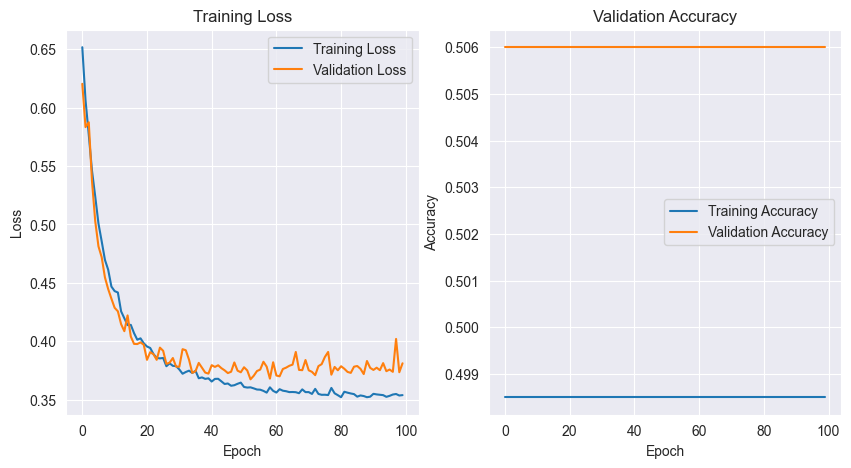

In [41]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [42]:
nn = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)
y_pred = nn.predict(X_test)

In [43]:
pred = np.argmax(y_pred.data, axis=1)

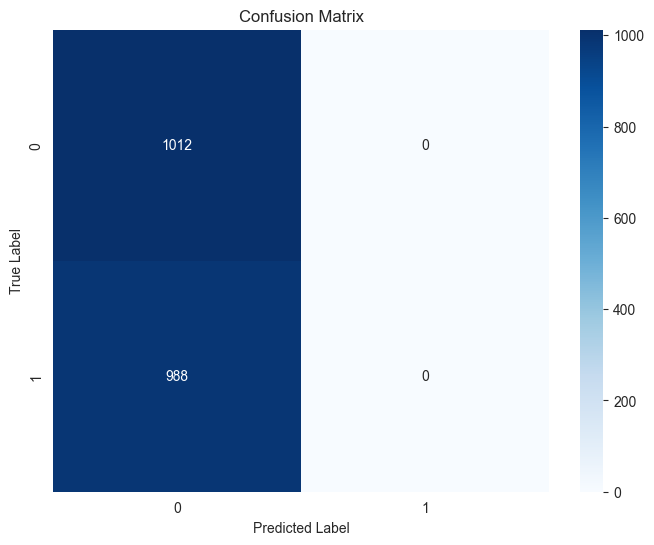

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_pred, axis=1))